In [23]:
import os
import io

# import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import feature
from skimage import filters
from skimage import morphology

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

In [3]:
DATA_DIR = '/Volumes/easystore/kaggle'
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_RESIZE_DIR = os.path.join(DATA_DIR, 'train_resize')
TEST_RESIZE_DIR = os.path.join(DATA_DIR, 'test_resize')

In [3]:
def get_n_samples(DIR):
    n_samples = 0
    for i in os.listdir(DIR):
        if i == '.DS_Store':
            continue
        for j in os.listdir(os.path.join(DIR, i)):
            if j == '_labels.csv':
                continue
            for k in os.listdir(os.path.join(DIR, i, j)):
                n_samples += len(os.listdir(os.path.join(DIR, i, j, k)))
    return n_samples

In [4]:
n_train_samples = get_n_samples(TRAIN_DIR)
n_test_samples = get_n_samples(TEST_DIR)

'{} training samples, {} test samples'.format(n_train_samples, n_test_samples)

NotADirectoryError: [Errno 20] Not a directory: '/Volumes/easystore/kaggle/train/_labels.csv'

In [4]:
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
test_labels = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
train_labels.head()

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


In [5]:
test_labels.head()

,image_id,InChI
0,00000d2a601c,InChI=1S/H2O/h1H2
1,00001f7fc849,InChI=1S/H2O/h1H2
2,000037687605,InChI=1S/H2O/h1H2
3,00004b6d55b6,InChI=1S/H2O/h1H2
4,00004df0fe53,InChI=1S/H2O/h1H2


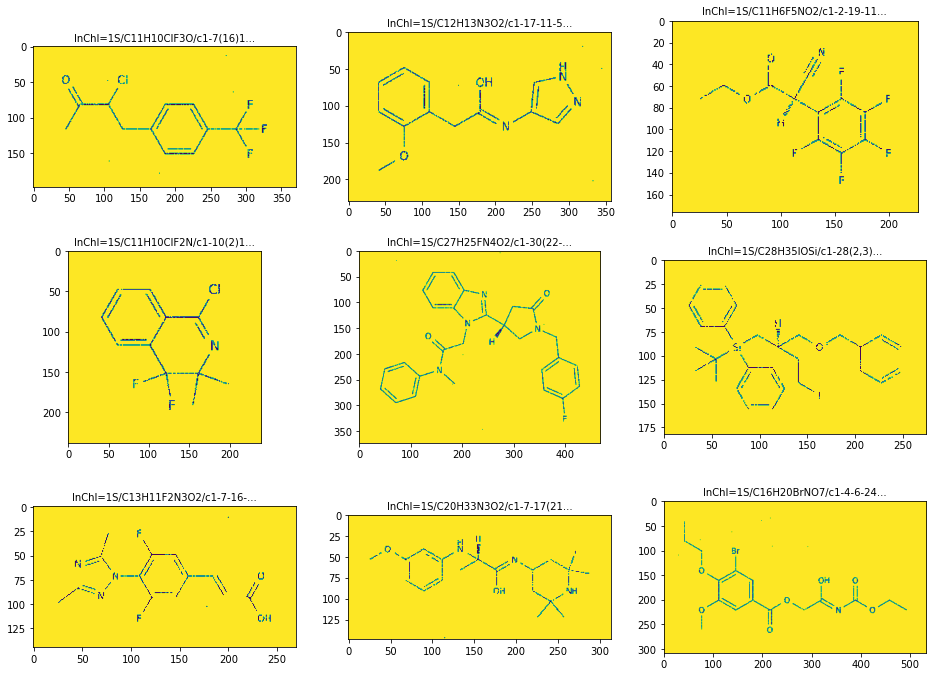

In [6]:
def get_path_from_img_id(img_id, load_dir='train'):
    if load_dir == 'train':
        DIR = TRAIN_DIR
    elif load_dir == 'test':
        DIR = TEST_DIR
    elif load_dir == 'train_resize':
        DIR = TRAIN_RESIZE_DIR
    elif load_dir == 'test_resize':
        DIR = TEST_RESIZE_DIR
    img_path = os.path.join(DIR, img_id[0], img_id[1], img_id[2], '{}.png'.format(img_id))
    return img_path

def visualize_sample(train_labels):
    plt.figure(figsize=(16,12))
    sample = train_labels.sample(n=9)
    img_ids = sample.image_id.values
    labels = sample.InChI.values
    for idx, (img_id, label) in enumerate(zip(img_ids, labels)):
        plt.subplot(3, 3, idx+1)
        img_path = get_path_from_img_id(img_id, load_dir='train')
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"{label[:30]}...", fontsize=10)
#         plt.title("{} height, {} width".format(img.shape[0], img.shape[1]))
    plt.show()

def visualize_img_id(img_id):
    plt.figure(figsize=(16,12))
    img_path = get_path_from_img_id(img_id, load_dir='train')
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.show()

visualize_sample(train_labels)

## Denoising

In [72]:
def get_n_samples(train_labels, n = 2):
    samples = train_labels.sample(n=n)
    img_ids = samples.image_id.values
    labels = samples.InChI.values
    
    imgs = []
    for im_id in img_ids:
        img_path = get_path_from_img_id(im_id, load_dir = 'train')
        imgs.append(plt.imread(img_path))
    
    return imgs, img_ids, labels


from PIL import Image, ImageOps

def pillow_pad(img, desired_size, color=(255,255,255,0), resample=Image.LANCZOS, copy=False):
    if copy:
        img = img.copy()
    
    old_size = img.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img.thumbnail(new_size, resample)
    
    new_img = Image.new('RGB', (desired_size, desired_size), color=color)
    new_img.paste(img, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    return new_img

def resize_imgs(img_ids, save_dir='train', resize=256):
    imgs = []
    if type(img_ids) == list:
        for i, img_id in enumerate(img_ids):
            img_path = get_path_from_img_id(img_id, load_dir='train')
            img = Image.open(img_path)
            img = pillow_pad(img, resize)
            img = img.convert('L')
            img = np.array(img)
            imgs.append(img)
            
    else:
        img_path = get_path_from_img_id(img_ids, load_dir='train')
        img = Image.open(img_path)
        img = pillow_pad(img, resize)
        img = img.convert('L')
        img = np.array(img)
        imgs.append(img)

    return imgs

def invert_and_normalize_img(img):
    new_im = (255 - img) / 255
    return new_im

def binarize(img):
#     thresh = filters.threshold_yen(img)
    thresh = 0.3
    binary = img > thresh
    return binary

def dilate(img):
    dilated = morphology.dilation(img, selem = morphology.octagon(1, 1))
    return dilated

def erode(img):
    eroded = morphology.erosion(img, selem = morphology.octagon(1, 1))
    return eroded

def edge_enhance(img):
    sharpened = filters.unsharp_mask(img, radius = 4, amount = 3)
    return sharpened

def edge_detect(img):
#     edges = feature.canny(img)
    edges = filters.sobel(img)
    return edges

def skeletonize(img):
    skeleton = morphology.skeletonize(img, method = 'lee')
    return skeleton

def fourier_filter(img, compression_percent = 95):
    h, w = img.shape
    
    def remove_small_magnitude_freqs(f_img_shift, h, w, compression_percent):
        mags = np.abs(f_img_shift)
        thresh = np.percentile(mags, compression_percent)
        cond = np.abs(f_img_shift) < thresh
        f_img_shift[cond] = 0
        
        return f_img_shift
    
    f_img = fft2(img)
    f_img_shift = fftshift(f_img)
    f_img_shift = remove_small_magnitude_freqs(f_img_shift, h, w, compression_percent)
    
    f_img = ifftshift(f_img_shift)
    filtered = np.real(ifft2(f_img))
        
    return filtered

# def ridge_detection(img):
#     #hessian filter?
#     return ridges

# def denoiser(img):
    #TV norm denoiser?
    #return denoised
    

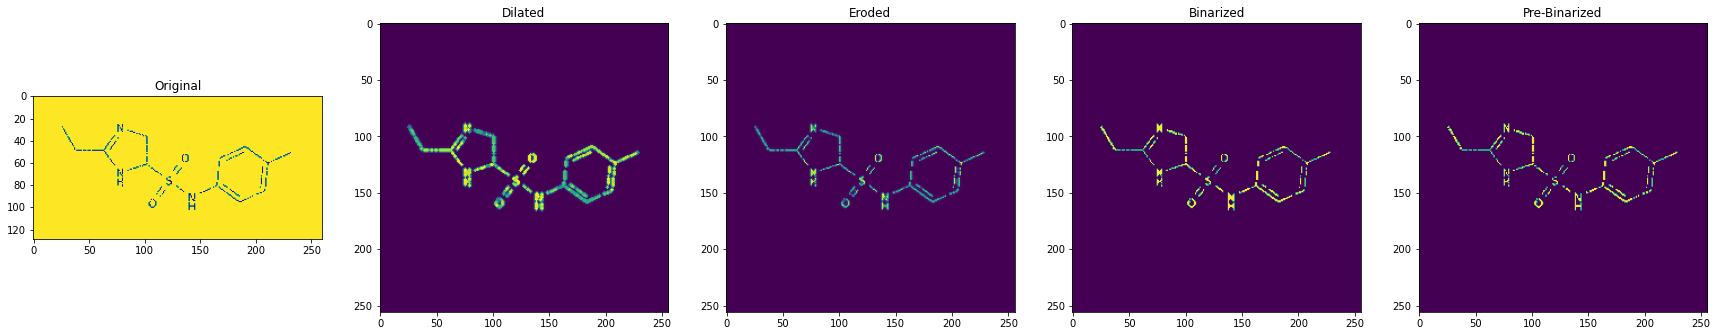

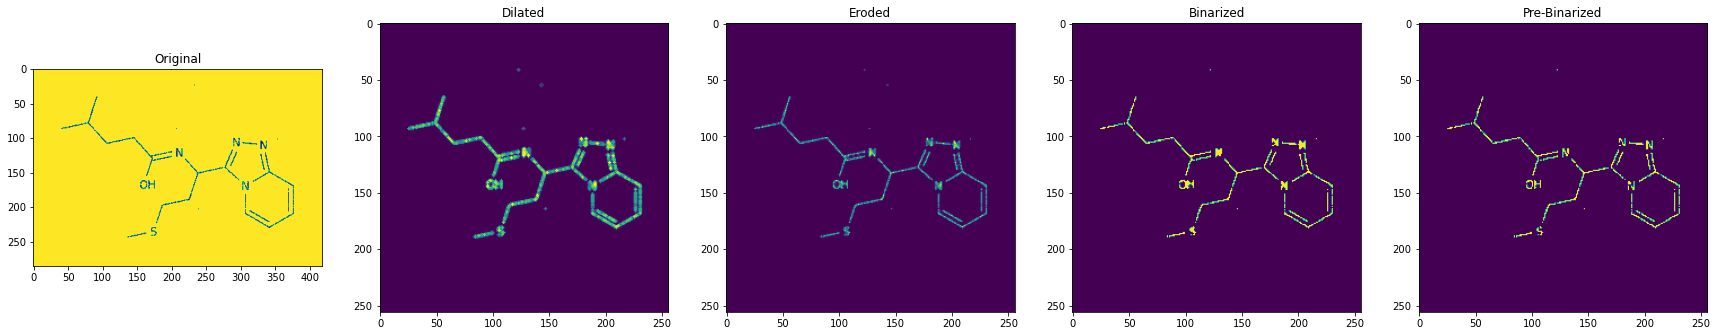

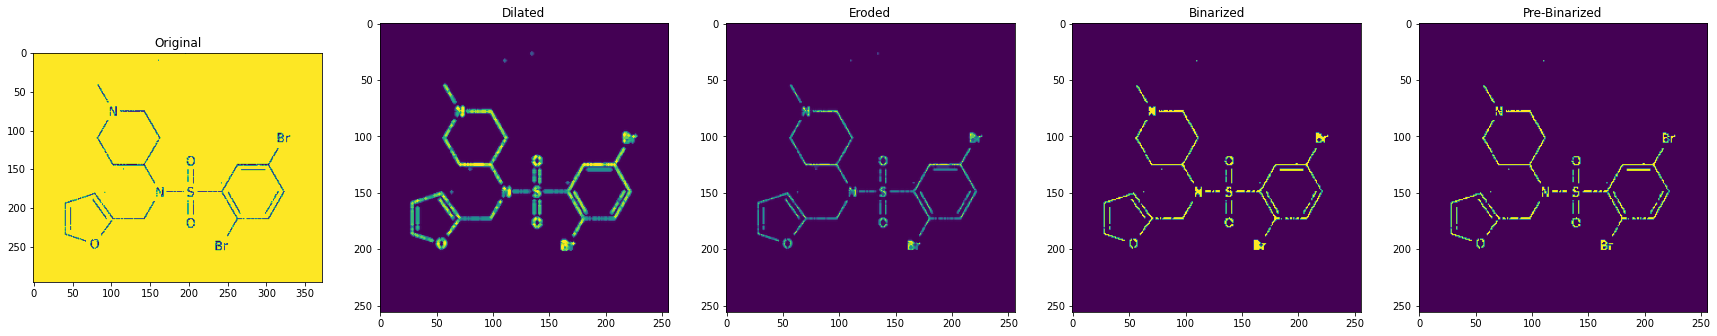

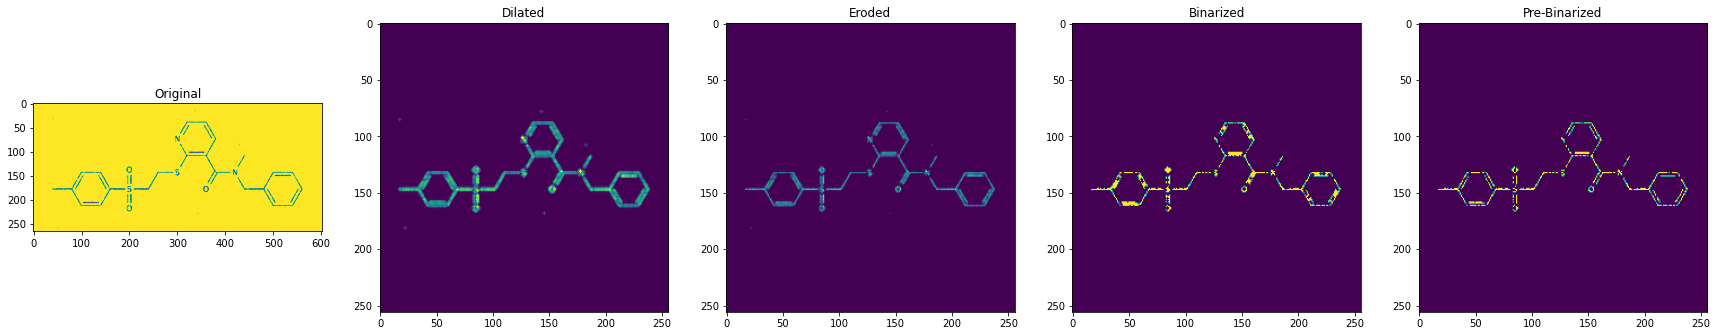

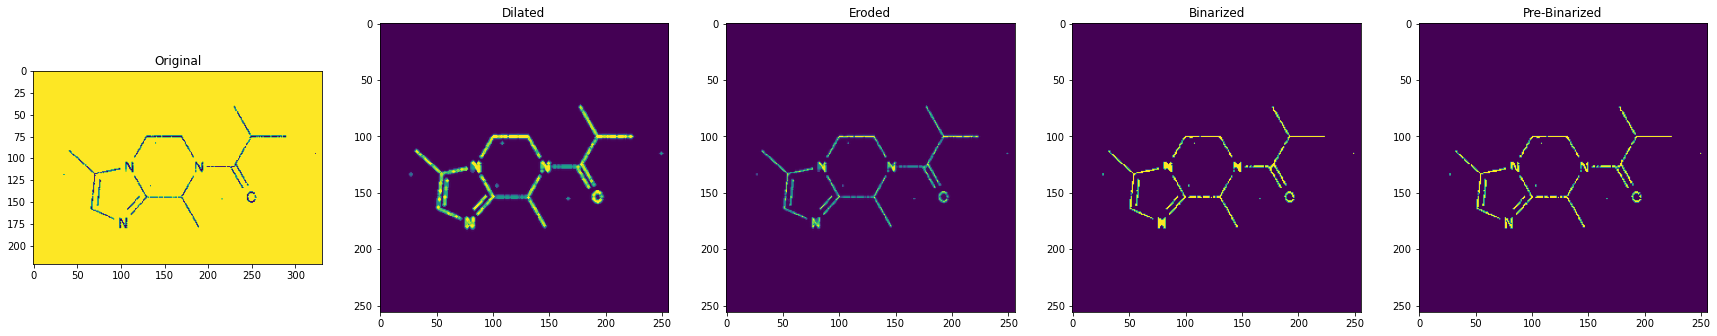

In [73]:
imgs, img_ids, labels = get_n_samples(train_labels, n = 5)

for i in range(len(img_ids)):
    fig, axs = plt.subplots(1, 5, figsize = (30, 6))
    axs = np.ravel(axs)
    
    resized = resize_imgs(img_ids[i], resize = 256)
    inverted = invert_and_normalize_img(resized[0])
    dilated = dilate(inverted)
#     filtered = fourier_filter(dilated, compression_percent = 95)
#     edges = edge_enhance(inverted)
    eroded = erode(dilated)
#     skeleton = skeletonize(eroded)
    binarized = binarize(eroded)
    prebinarized = binarize(inverted)
    
    axs[0].imshow(imgs[i])
    axs[0].set_title('Original')
    
#     axs[1].imshow(resized[0])
#     axs[1].set_title('Resized')
    
#     axs[2].imshow(inverted)
#     axs[2].set_title('Inverted')
    
#     axs[3].imshow(filtered)
#     axs[3].set_title('Dilated and Eroded')
    
#     axs[4].imshow(edges)
#     axs[4].set_title('Edge Detection')
    
#     axs[1].imshow(edges)
#     axs[1].set_title('Edge Enhancement')
    
    axs[1].imshow(dilated)
    axs[1].set_title('Dilated')
    
    axs[2].imshow(eroded)
    axs[2].set_title('Eroded')
    
    axs[3].imshow(binarized)
    axs[3].set_title('Binarized')
    
    axs[4].imshow(prebinarized)
    axs[4].set_title('Pre-Binarized')
    
    

plt.show()